In this example we will consider the mechanism of interaction with API of FEDOT.Industrial framework to solve the problem of time series classification

First of all, it is necessary to import the base class FedotIndustrial and determine the parameters of the experiment

In [1]:
from fedot_ind.core.architecture.preprocessing.DatasetLoader import DataLoader
from fedot_ind.api.main import FedotIndustrial

The parameters of the experiment are:

In [3]:
industrial = FedotIndustrial(task='ts_classification',
                             dataset='ItalyPowerDemand',
                             strategy='quantile',
                             use_cache=False,
                             timeout=5,
                             n_jobs=2,
                             logging_level=60)

2023-08-28 12:35:04,149 - Initialising experiment setup
2023-08-28 12:35:04,151 - Experiment setup:
2023-08-28 12:35:04,152 - task - ts_classification
2023-08-28 12:35:04,154 - dataset - ItalyPowerDemand
2023-08-28 12:35:04,155 - strategy - quantile
2023-08-28 12:35:04,155 - use_cache - False
2023-08-28 12:35:04,157 - Initialising solver
2023-08-28 12:35:04,159 - TimeSeriesClassifier initialised


Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
train_data, test_data = DataLoader(dataset_name='ItalyPowerDemand').load_data()

2023-08-28 12:35:12,911 - Data not found in /Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/fedot_ind/data/ItalyPowerDemand
2023-08-28 12:35:12,913 - Downloading...
2023-08-28 12:35:13,216 - ItalyPowerDemand data downloaded. Unpacking...
2023-08-28 12:35:13,218 - Reading data from /Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/temp_cache/temp_data//ItalyPowerDemand
2023-08-28 12:35:13,250 - Saving ItalyPowerDemand data files


Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train Fedot classification model.

In [5]:
model = industrial.fit(features=train_data[0], target=train_data[1])

2023-08-28 12:35:27,963 - Fitting model


Generations:   0%|          | 1/10000 [04:48<?, ?gen/s]


The output of the `fit` method is the trained Fedot model in the form of `pipeline` that can be used for prediction.

Actually, we have access to it and are able to visualize:

{'depth': 3, 'length': 6, 'nodes': [logit, catboost, isolation_forest_class, normalization, mlp, poly_features]}


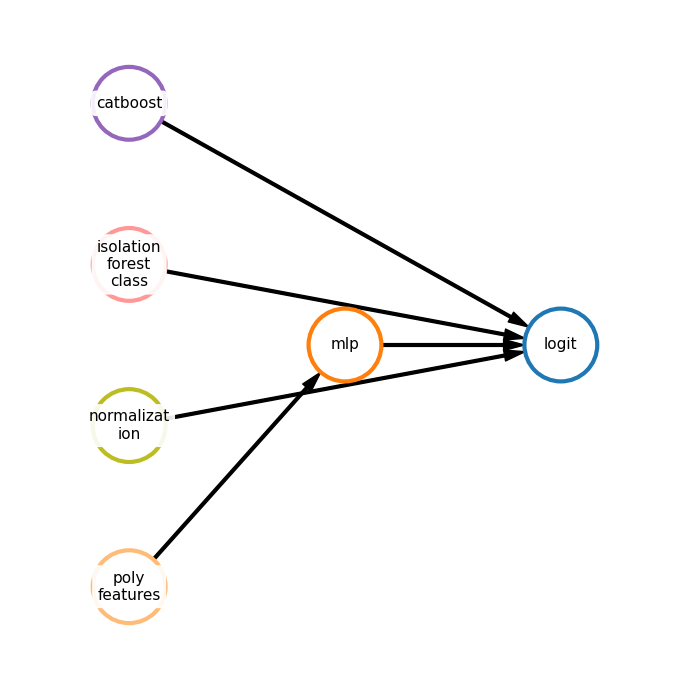

In [6]:
print(model.current_pipeline)

model.current_pipeline.show(node_size_scale=1)

Next, we can predict the values for the test data. In the case of time series classification, the output of the model is the predicted class for each time series in the test data or the probability of belonging to each class.

In [8]:
labels = industrial.predict(features=test_data[0])

print(labels)

[[2]
 [2]
 [2]
 ...
 [1]
 [2]
 [2]]


In [10]:
probs = industrial.predict_proba(features=test_data[0])

print(probs)

[[0.80246635]
 [0.58993187]
 [0.89981574]
 ...
 [0.3056659 ]
 [0.94572621]
 [0.92363046]]


At the end of the experiment we can obtain the desired metric values using `get_metrics` method. Now there are five available metrics for classification task:
- `f1`
- `roc_auc`
- `accuracy`
- `precision`
- `recall`.

Let's say we want to get the `roc_auc` metric for the test data since ItalyPowerDemand dataset is binary.

In [11]:
metric = industrial.get_metrics(target=test_data[1],
                                metric_names=['roc_auc'])
print(metric)

{'roc_auc': 0.892}


Also, there is an opportunity to save metrics, predicted labels and probabilities to the csv file:

In [12]:
for pred in [labels, probs]:
    industrial.save_predict(predicted_data=pred)

industrial.save_metrics(metrics=metric)